## Imports

In [1]:
import os
import sys
sys.path.insert(0, '../utils')
import transfer_utils 
import model_utils
import data_utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import numpy as np
import pandas as pd

import torchsummary
import torchvision
import torch
from transfer_model import NTLModel

import warnings
warnings.filterwarnings("ignore")

use_gpu = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(use_gpu)
print("Using gpu: ", use_gpu)

%load_ext autoreload
%autoreload 2

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Using gpu:  cuda


## File Locations

In [2]:
# Google Cloud Storage
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'
image_directory = directory + '/images'

# Destination files
report_file = '../data/report.csv'
nightlights_unstacked_file = '../data/nightlights_unstacked.csv'

dhs_indicators_file = '../data/dhs_indicators.csv'
dhs_provinces_file = '../data/dhs_provinces.csv'
dhs_regions_file = '../data/dhs_regions.csv'

gsm_data_dir = '../data/images/' 
model_file = '../models/model_best.pt'
feature_embeddings_file = '../data/embeddingsv2.csv'
embeddings_indicators_file = '../data/indicators.csv'

# Test images for sanity checking purposes
high1_file = '../data/test_images/high1.jpg'
high2_file = '../data/test_images/high2.jpg'
low1_file = '../data/test_images/low1.jpg'
low2_file = '../data/test_images/low2.jpg'

## Download Files

## Load Datasets

In [3]:
report = pd.read_csv(report_file)
nightlights_unstacked = pd.read_csv(nightlights_unstacked_file)
dhs_indicators = pd.read_csv(dhs_indicators_file)
dhs_regions = pd.read_csv(dhs_regions_file)
dhs_provinces = pd.read_csv(dhs_provinces_file)

## Instantiate Transfer Model

In [4]:
# Load data
dataloaders, dataset_sizes, class_names = transfer_utils.load_transform_data(
    data_dir=gsm_data_dir, batch_size=4
)

# Instantiate model
model = torchvision.models.vgg16(pretrained=True)
model = NTLModel(model, len(class_names))
if use_gpu == "cuda":
    model = model.cuda()
    
# Load saved model
checkpoint = torch.load(model_file)
model.load_state_dict(checkpoint['state_dict'])

# Visualize model
torchsummary.summary(model, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

## Visualize Nighttime Light Intensity Classification Predictions

<Figure size 432x288 with 0 Axes>

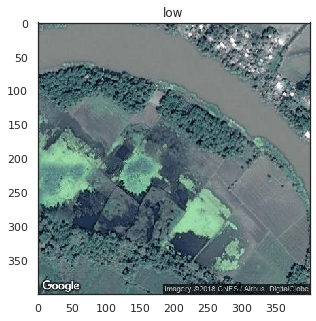

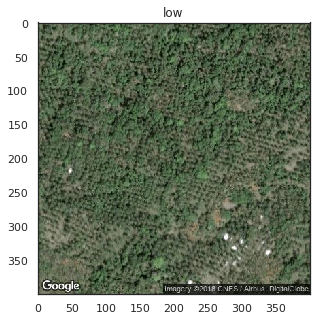

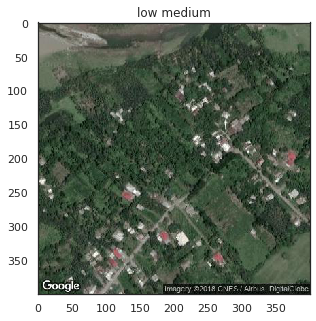

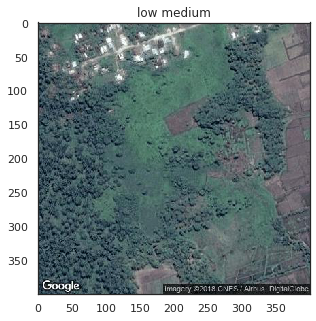

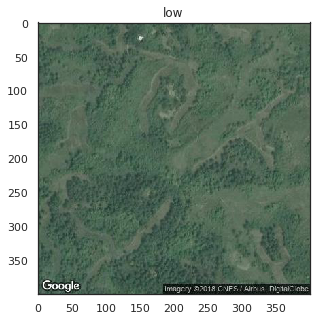

In [6]:
transfer_utils.visualize_model(model, dataloaders, class_names, 5, size=(5,5));

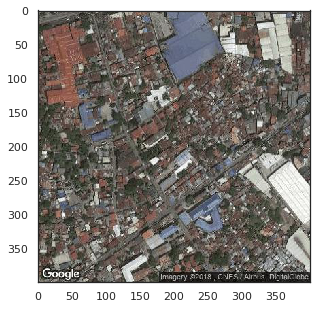

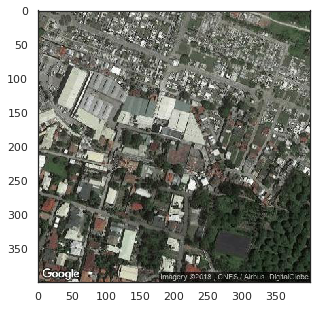

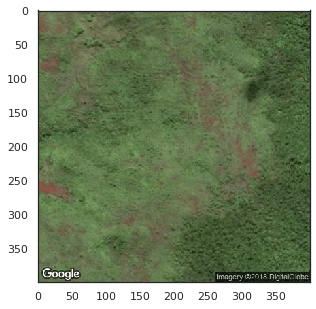

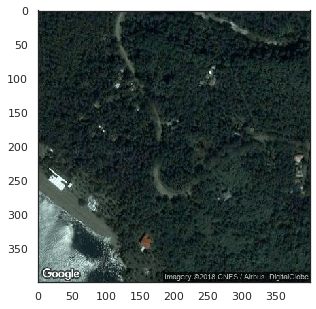

Embedding size: torch.Size([1, 4096])
Cosine similarity between 2 high nightlight intensity images: tensor([0.9794])
Cosine similarity between 2 low nightlight intensity images: tensor([0.9665])
Cosine similarity between 1 low and 1 high: tensor([0.5172])
Cosine similarity 1 high and 1 low: tensor([0.6518])


In [7]:
# Get feature embeddings for selected test images
high1_embedding = transfer_utils.get_embedding(high1_file, model, gpu=True)
high2_embedding = transfer_utils.get_embedding(high2_file, model, gpu=True)
low1_embedding = transfer_utils.get_embedding(low1_file, model, gpu=True)
low2_embedding = transfer_utils.get_embedding(low2_file, model, gpu=True)

# Display test images
figsize = (5,5)
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(high2_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low1_file))
plt.show()
plt.figure(figsize=figsize)
plt.imshow(mpimg.imread(low2_file))
plt.show()

# Sanity check: Get cosine similarity between feature embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Embedding size: {}".format(high1_embedding.size()))
print('Cosine similarity between 2 high nightlight intensity images: {0}'.format(cos(high1_embedding,high2_embedding)))
print('Cosine similarity between 2 low nightlight intensity images: {0}'.format(cos(low1_embedding,low2_embedding)))
print('Cosine similarity between 1 low and 1 high: {0}'.format(cos(low1_embedding,high2_embedding)))
print('Cosine similarity 1 high and 1 low: {0}'.format(cos(high1_embedding,low2_embedding)))

## Generate feature embedding per cluster

In [ ]:
# Get feature embedding per image
report.filename = report.filename.str.replace('../../data/gsm_data/images/', '../data/images/')
report = nightlights_unstacked.merge(report, left_on='ID', right_on='id', how='left')
report = transfer_utils.get_embedding_per_image(report, model)
print("Report shape: {}".format(report.shape))

# Sanity check: Get feature embedding for 1 high light intensity image and 1 low intensity image
high = torch.from_numpy(np.array([report[report['label'] == 'high'].iloc[0]['embeddings']]))
low = torch.from_numpy(np.array([report[report['label'] == 'low'].iloc[5]['embeddings']]))

# Sanity Check: Cosine similarity between pairs of images
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
print("Cosine similarity is: {}".format(cos(low, high)))

  6%|▌         | 10136/173580 [06:39<1:20:26, 33.86it/s]

In [8]:
# Get mean feature embedding per cluster
cluster_embeddings = transfer_utils.get_mean_embedding_per_cluster(report)

# Merge cluster embeddings with DHS indicators
cluster_embeddings = cluster_embeddings.merge(dhs_indicators, left_on='cluster', right_on='Cluster number')
feature_embeddings = cluster_embeddings.mean_embedding.apply(pd.Series)

# Save embeddings 
feature_embeddings.to_csv(feature_embeddings_file)
cluster_embeddings.to_csv(embeddings_indicators_file)

100%|██████████| 1214/1214 [00:01<00:00, 674.02it/s]


## Machine Learning Pipeline

In [4]:
scoring = {
    'r2': data_utils.pearsonr2,
    'rmse': data_utils.rmse
}

indicators = [
    'Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

In [12]:
# Load embedding features
embeddings_df = pd.read_csv(feature_embeddings_file).iloc[:, 1:]
cluster_embeddings = pd.read_csv(embeddings_indicators_file)

region_cols = list(dhs_regions.columns[:-1])
province_cols = list(dhs_provinces.columns[:-1])
embedding_cols = list(embeddings_df.columns) 

# Merge with DHS indicators
embeddings_df['Cluster number'] = cluster_embeddings['Cluster number']
data = embeddings_df.merge(cluster_embeddings, on='Cluster number')

# Merge with regional and provincial indicators
data = data.merge(dhs_provinces, on='Cluster number', how='left')
data = data.merge(dhs_regions, on='Cluster number', how='left')
data = data.fillna(0)

print(data.shape)

(1213, 4209)


## t-SNE Visualization

In [6]:
embeddings = data.iloc[:, :4096]
feature_cols = embeddings.columns

embeddings['Cluster number'] = data['Cluster number']
embeddings['Wealth Index'] = data['Wealth Index']

# Sanity check embeddings
data.iloc[:, [-7, 0, 1, 2]].tail(3)

,mean_embedding,0,1,2
1210,[0.3263449 0.21861307 0.36785838 ... 0.295240...,0.326345,0.218613,0.367858
1211,[0.37139875 0.29570895 0.466432 ... 0.380368...,0.371399,0.295709,0.466432
1212,[0.37248164 0.2121675 0.40740678 ... 0.266922...,0.372482,0.212168,0.407407


In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings[feature_cols].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1213 samples in 0.354s...
[t-SNE] Computed neighbors for 1213 samples in 6.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1213
[t-SNE] Computed conditional probabilities for sample 1213 / 1213
[t-SNE] Mean sigma: 1.838341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.270271
[t-SNE] KL divergence after 300 iterations: 0.715780


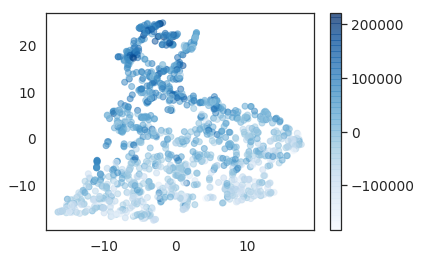

In [13]:
embeddings['x-tsne'] = tsne_results[:,0]
embeddings['y-tsne'] = tsne_results[:,1]

f, ax = plt.subplots()
points = ax.scatter(embeddings['x-tsne'], embeddings['y-tsne'], c=embeddings['Wealth Index'], cmap='Blues', alpha=0.5)
f.colorbar(points)

## Machine Learning Pipeline

### Using CNN feature embeddings + Regional indicators

Socioeconomic indicator: Wealth Index
train_rmse : 37074.2516
[36855.47457758 37960.45161472 36319.36920411 37629.29689911
 36606.66576541]
test_r2 : 0.6252
[0.65852924 0.59119029 0.63132793 0.63596036 0.60921444]
train_r2 : 0.7290
[0.72889777 0.72850086 0.72476293 0.72293437 0.73989498]
score_time : 0.0613
[0.07187819 0.06601405 0.08518434 0.06728673 0.01604652]
test_rmse : 43274.3443
[42413.79685054 41173.39608997 47596.85684588 42170.55240821
 43017.11922484]
fit_time : 18.7687
[21.83589292 21.76688886 21.4651947  21.50967383  7.26581526]


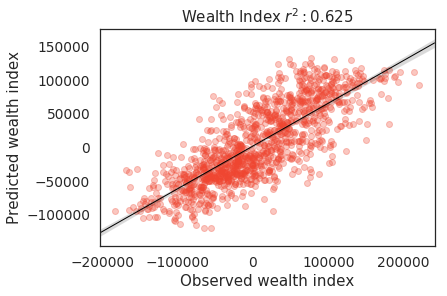

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=2.9279757672456204, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])
Socioeconomic indicator: Education completed (years)
train_rmse : 1.4496
[1.46917337 1.4777657  1.47386622 1.48294375 1.34431727]
test_r2 : 0.4693
[0.4984105  0.41204837 0.53070079 0.49276559 0.41236586]
train_r2 : 0.6226
[0.61531294 0.62922814 0.58445762 0.6006886  0.68306574]
score_time : 0.0662
[0.07857203 0.08288264 0.08534718 0.07546496 0.00856352]
test_rmse : 1.7086
[1.65243125 1.61564925 1.8004189  1.71549428 1.75879919]
fit_time : 18.9738
[21.86267447 21.84245777 22.04730558 22.14737082  6.96931624]


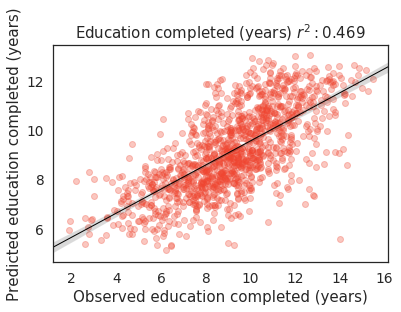

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=2.9279757672456204, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])
Socioeconomic indicator: Access to electricity
train_rmse : 0.1051
[0.10561753 0.10800775 0.09818248 0.1059265  0.10800144]
test_r2 : 0.2737
[0.27460147 0.26567298 0.35307472 0.28381724 0.19155422]
train_r2 : 0.4857
[0.49623104 0.47671252 0.4591615  0.47998289 0.51636606]
score_time : 0.0564
[0.08012557 0.05286956 0.08421326 0.04321551 0.02146912]
test_rmse : 0.1229
[0.11792725 0.11672308 0.15409209 0.12373409 0.10190874]
fit_time : 19.2329
[22.00271463 22.03800392 22.33559608 22.45787621  7.330446  ]


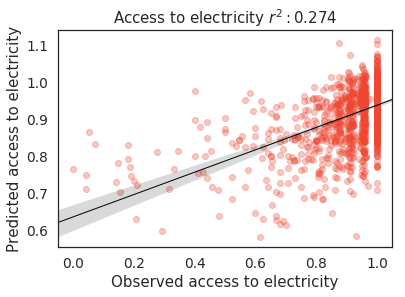

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.8028572256396647, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])
Socioeconomic indicator: Access to water (minutes)
train_rmse : 7.2771
[5.87069574 8.43774002 7.32068514 7.68160624 7.07454806]
test_r2 : 0.0969
[0.10538892 0.14217108 0.06145865 0.0752669  0.1003689 ]
train_r2 : 0.2325
[0.28077438 0.12839506 0.22470704 0.13366718 0.39473381]
score_time : 0.0542
[0.06845045 0.09586906 0.06768751 0.02972794 0.0093329 ]
test_rmse : 7.4425
[11.70255367  3.65772609  8.24545696  8.00413444  5.60260641]
fit_time : 19.1625
[22.12792158 22.03098607 22.00622392 22.4202354   7.22699022]


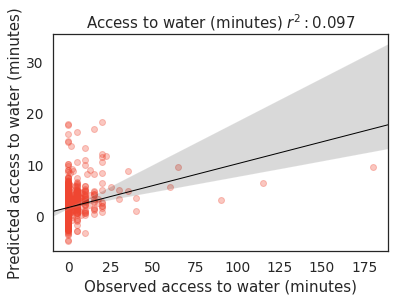

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.8028572256396647, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])


In [8]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols+region_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 
)
predictions.to_csv("output/transfer_reg_predictions.csv", index=False)

### Using CNN feature embeddings 

Socioeconomic indicator: Wealth Index
train_r2 : 0.7176
[0.74273738 0.71649895 0.70666488 0.71016253 0.71214366]
score_time : 0.0285
[0.03448868 0.0380466  0.02148819 0.03600287 0.01233983]
train_rmse : 37905.8117
[36046.39783885 38852.64844609 37556.8491664  38541.02887965
 38532.13413197]
test_r2 : 0.5929
[0.62990891 0.54786351 0.62018516 0.59169206 0.57477079]
test_rmse : 45083.8954
[44208.30236087 43403.94184177 48319.22500158 44628.93408033
 44859.07395003]
fit_time : 17.1328
[19.91544867 20.1252389  20.05970645 19.22093248  6.34256601]


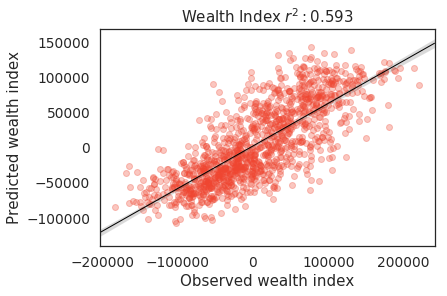

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])
Socioeconomic indicator: Education completed (years)
train_r2 : 0.5876
[0.64198664 0.58426381 0.47895203 0.57343483 0.65922985]
score_time : 0.0225
[0.03518438 0.01093364 0.01717186 0.03614974 0.0132966 ]
train_rmse : 1.5122
[1.42480366 1.56346436 1.64477717 1.5329574  1.39495851]
test_r2 : 0.4369
[0.47274992 0.38750234 0.47495834 0.46434704 0.38476556]
test_rmse : 1.7631
[1.69776839 1.6470364  1.90871549 1.76496585 1.79721708]
fit_time : 17.4125
[20.02239013 20.27530932 20.16686869 19.88619494  6.71198583]


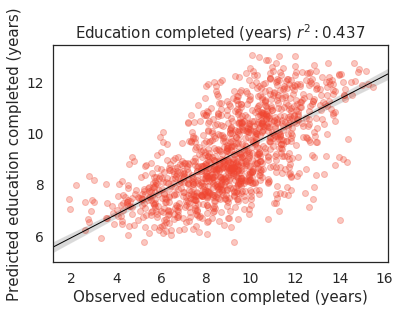

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=2.9279757672456204, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])
Socioeconomic indicator: Access to electricity
train_r2 : 0.4285
[0.5147105  0.30416306 0.42122134 0.44053207 0.46197782]
score_time : 0.0306
[0.03209782 0.02346039 0.03980565 0.04454207 0.01299095]
train_rmse : 0.1110
[0.10468017 0.12387548 0.10183988 0.11035137 0.11426297]
test_r2 : 0.2231
[0.20435981 0.21462438 0.25958565 0.26584779 0.1709886 ]
test_rmse : 0.1268
[0.12385178 0.11959149 0.16311801 0.12509724 0.10249732]
fit_time : 17.1714
[19.76056147 20.0734005  19.92348123 19.59138775  6.50836992]


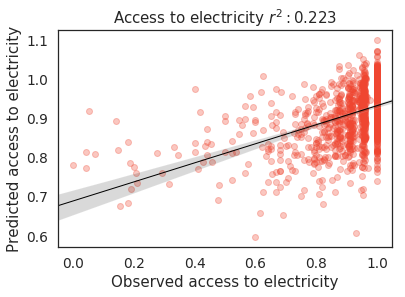

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=3.8028572256396647, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001))])
Socioeconomic indicator: Access to water (minutes)
train_r2 : 0.2421
[0.35864994 0.10012288 0.11362012 0.10901744 0.52923957]
score_time : 0.0166
[0.00582862 0.02778578 0.02439237 0.01998162 0.00518417]
train_rmse : 7.2398
[5.67424662 8.53869763 7.69507618 7.76052415 6.53035958]
test_r2 : 0.0594
[0.04516758 0.11323523 0.04694817 0.0491715  0.04252137]
test_rmse : 7.5878
[12.00019318  3.74573433  8.30998405  8.10951132  5.7735144 ]
fit_time : 17.1213
[20.07495046 19.56839061 19.86033106 19.58910322  6.51364255]


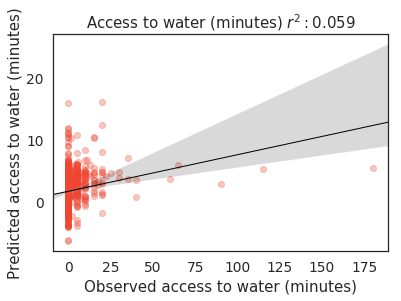

Best estimator: Pipeline(memory=None,
     steps=[('regressor', Ridge(alpha=1.49816047538945, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))])


In [14]:
predictions = model_utils.evaluate_model(
    data=data,
    feature_cols=embedding_cols, 
    indicator_cols=indicators, 
    scoring=scoring,
    model_type='ridge', 
    refit='r2', 
    search_type='grid', 
    n_splits=5 
)